In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 3.1 Approche statistique

## 1. Pourquoi est-on si attaché au fait que notre série temporelle soit stationnaire?


Dans une regression linéaire les variables explicatives ne doivent pas être collinéaires entre elle. Or quand il y a un trend ou une saisonnalité, il y a un lien. Donc on cherche à supprimer ce lien pour ne garder qu'un pattern.

## 2-5. Les paramètres de Sarima

- AR ‘Auto Regressive’: p le nombre de lag qu'on va intégrer au modèle, globalement la complexité du micro pattern entre Y et ses lags quand on enlève trend et saison
- MA ‘Moving Average’: q le nombre de terme d'erreur à intégrer dans le modèle. Notre série temporelle dépend de ses lags mais aussi de plein d'autre chose (la météo par exemple ou le prix de l'electricité). Toutes ces "autres choses" sont regroupées dans le terme d'erreur. On suppose qu'il y a un micro pattern entre les termes d'erreur et le y qu'on veut prédire.
- I  'Integrated": d le nombre de fois ou il faut différencier pour enlever le trend. C'est une sorte de dérivée pour ceux qui connaissent quand la tendance est linéaire, il faut dériver une fois et quand la tendance quadratique, il faut dériver 2 fois.
-  S 'saisonnalité": s est la plage de saisonnalité. Quand chaque point est un jour alors s=7 permet d'enlever la saisonnalité hebdommadaire, s=365 la saisonnalité annuelle. 

## 6 Déterminer s,d,q et p

### Déterminer s 

Nos boxplot nous ont montré que la saisonnalité la plus forte était celle mensuelle, on choisit donc un rolling windows à l'annéee pour supprimer cet effet.

In [15]:
df_day = pd.read_csv("../data/hdf_daily", index_col="date_heure", parse_dates = True)
df_rolling_year = df_day.rolling(window=365,center=False, win_type=None).mean()
df_rolling_year = df_rolling_year.dropna()

FileNotFoundError: [Errno 2] No such file or directory: '../data/hdf_daily'

<Axes: xlabel='date_heure'>

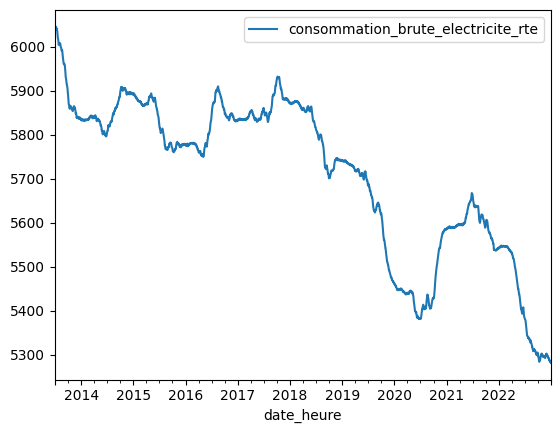

In [4]:
df_rolling_year.plot()

### Déterminer d

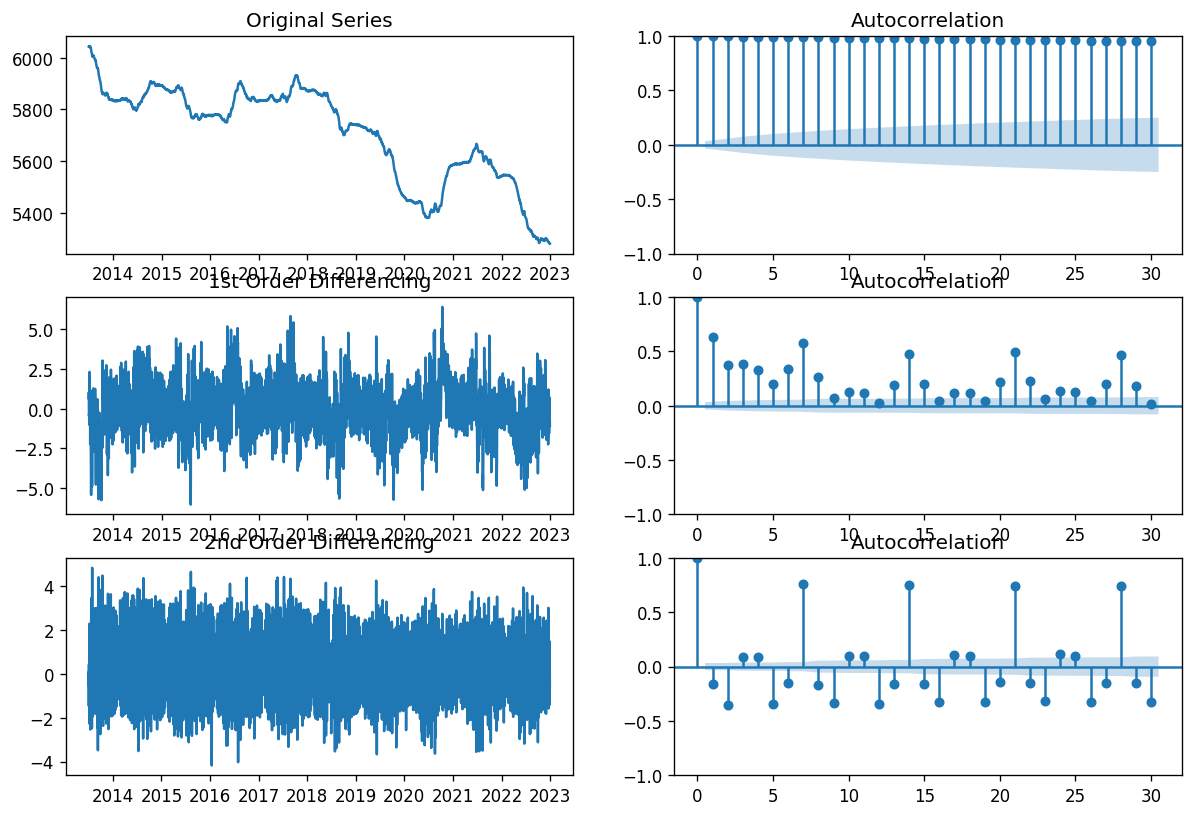

In [6]:
import numpy as np, pandas as pd
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

# Original Series
plt.rcParams.update({'figure.figsize':(12,8), 'figure.dpi':120})
fig, axes = plt.subplots(3, 2)
axes[0, 0].plot(df_rolling_year["consommation_brute_electricite_rte"]); axes[0, 0].set_title('Original Series')

plot_acf(df_rolling_year.consommation_brute_electricite_rte, lags = 30, ax=axes[0, 1])

# 1st Differencing
axes[1, 0].plot(df_rolling_year["consommation_brute_electricite_rte"].diff()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(df_rolling_year["consommation_brute_electricite_rte"].diff().dropna(), lags = 30, ax=axes[1, 1])

# 2nd Differencing
axes[2, 0].plot(df_rolling_year["consommation_brute_electricite_rte"].diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(df_rolling_year["consommation_brute_electricite_rte"].diff().diff().dropna(), lags = 30, ax=axes[2, 1])

plt.show()

Comme on pouvait le supposer d'après nos précédents graphiques d=1 (même argumentaire que dans la ressource)

### Déterminer p

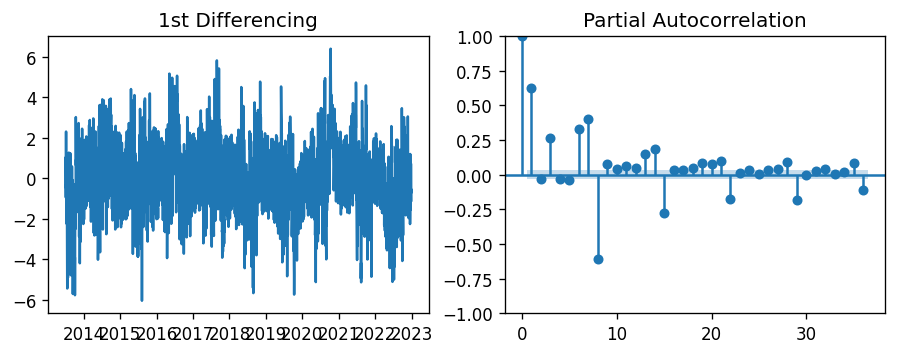

In [22]:
# PACF plot of 1st differenced series
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

fig, axes = plt.subplots(1, 2)
axes[0].plot(df_rolling_year["consommation_brute_electricite_rte"].diff()); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,5))
plot_pacf(df_rolling_year["consommation_brute_electricite_rte"].diff().dropna(), ax=axes[1])

plt.show()

Graphiquement p=1

### Déterminer q

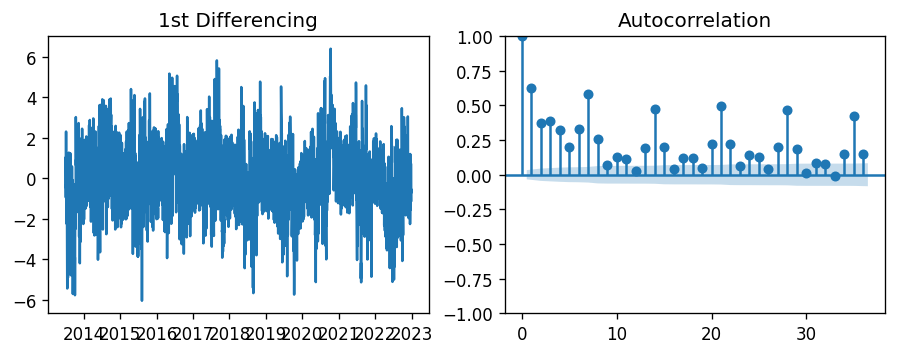

In [23]:
import pandas as pd
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

fig, axes = plt.subplots(1, 2)
axes[0].plot(df_rolling_year["consommation_brute_electricite_rte"].diff()); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,1.2))
plot_acf(df_rolling_year["consommation_brute_electricite_rte"].diff().dropna(), ax=axes[1])

plt.show()

Ici graphiquement on pourrait dire q = 4 meme si c'est beaucoup.

## 7. A l’aide statmodels, lancez un modèle ARIMA sur la série désaisonnalisée. 

In [15]:
from statsmodels.tsa.arima.model import ARIMA

# 1,1,2 ARIMA Model
model = ARIMA(df_rolling_year["consommation_brute_electricite_rte"], order=(1,1,4))
model_fit = model.fit()
print(model_fit.summary())

/Users/charles/miniconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/charles/miniconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/charles/miniconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


                                       SARIMAX Results                                        
Dep. Variable:     consommation_brute_electricite_rte   No. Observations:                 3470
Model:                                 ARIMA(1, 1, 4)   Log Likelihood               -5575.072
Date:                                Tue, 12 Sep 2023   AIC                          11162.143
Time:                                        10:07:13   BIC                          11199.053
Sample:                                    07-01-2013   HQIC                         11175.322
                                         - 12-30-2022                                         
Covariance Type:                                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1301      0.087     -1.489      0.137      -0.301       0.041
ma.

On voit ici que ar.L1 n'est pas significatif au seuil de 10% on pourrait enlever ce terme du modèle pour voir si ça améliore l'AIC

In [ ]:
from statsmodels.tsa.arima.model import ARIMA

# 1,1,2 ARIMA Model
model_2 = ARIMA(df_rolling_year["consommation_brute_electricite_rte"], order=(1,0,4))
model_fit_2 = model.fit()
print(model_fit_2.summary())

/Users/charles/miniconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/charles/miniconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/charles/miniconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/charles/miniconda3/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


                                       SARIMAX Results                                        
Dep. Variable:     consommation_brute_electricite_rte   No. Observations:                 3470
Model:                                 ARIMA(1, 0, 4)   Log Likelihood               -5594.072
Date:                                Mon, 11 Sep 2023   AIC                          11202.144
Time:                                        16:07:31   BIC                          11245.207
Sample:                                    07-01-2013   HQIC                         11217.519
                                         - 12-30-2022                                         
Covariance Type:                                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       5708.1459    362.353     15.753      0.000    4997.948    6418.344
ar.

On voit que l'AIC a augmenté ce qui est l'inverse de ce qu'on recherchait. Mon modèle n'est pas meilleur au global

## 8 Etudiez les résides

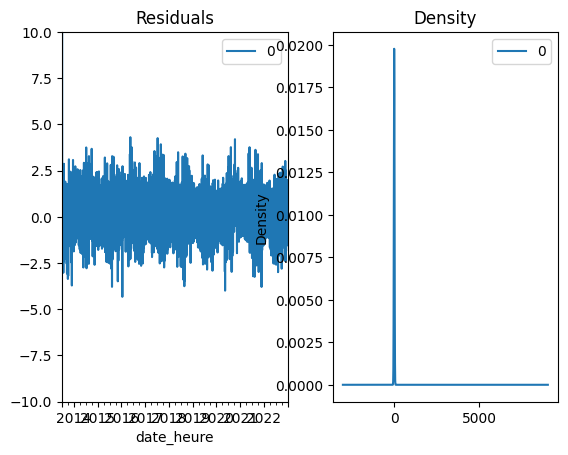

In [8]:
# Plot residual errors
residuals = pd.DataFrame(model_fit.resid)
fig, ax = plt.subplots(1,2)
ax[0].set_ylim(-10, 10)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

ça ressemble à du bruit blanc

In [17]:
type(model_fit)

statsmodels.tsa.arima.model.ARIMAResultsWrapper

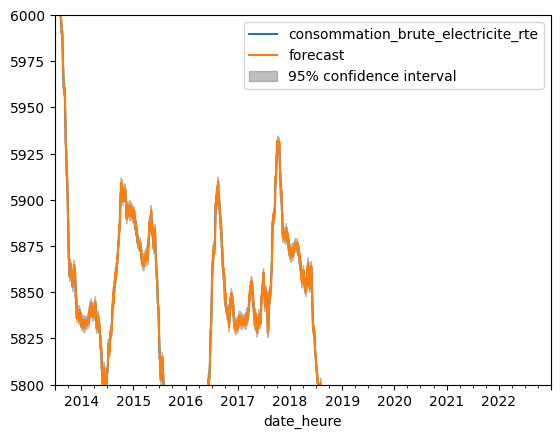

In [27]:

from statsmodels.graphics.tsaplots import plot_predict


fig, ax = plt.subplots()
ax = df_rolling_year["consommation_brute_electricite_rte"].plot(ax=ax)
plot_predict(model_fit, ax=ax)
ax.set_ylim(5800, 6000)
plt.show()

## 9. A l’aide de statmodels et pmdarima, lancez un auto ARIMA sur la série désaisonnalisée.

In [2]:
from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm

## 10. Entrainez le même modèle mais cette fois uniquement sur les dates de 2014 à 2020. Affichez les prédictions sur 2021-2023 

In [43]:
train = df_rolling_year["consommation_brute_electricite_rte"]['2014-01-01':'2020-12-31']
test = df_rolling_year["consommation_brute_electricite_rte"]['2021-01-01':'2022-12-30']

In [44]:
# Build Model
model = ARIMA(train, order=(1,1,4))
model_fit = model.fit()


# Forecast
fc = model_fit.forecast(len(test), alpha=0.05)  # 95% conf



/Users/charles/miniconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/charles/miniconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/charles/miniconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/charles/miniconda3/lib/python3.10/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


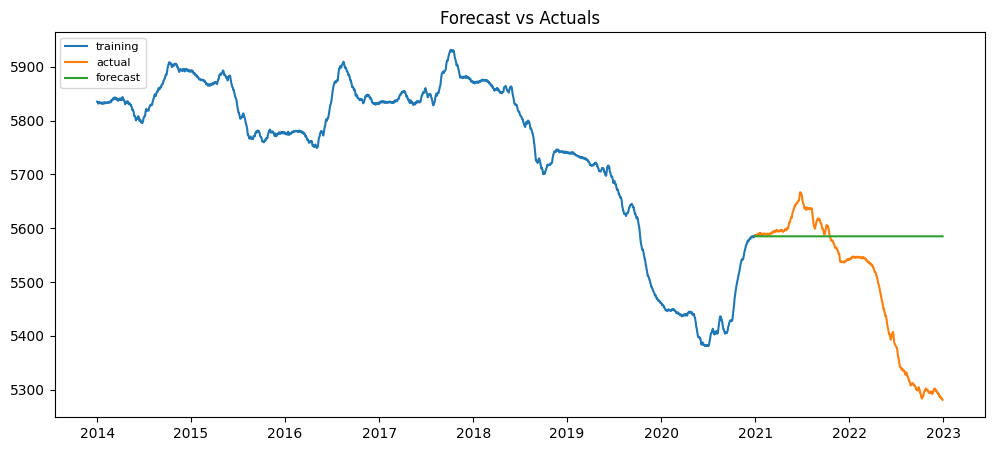

In [45]:
# Make as pandas series

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc, label='forecast')
# plt.fill_between(lower_series.index, lower_series, upper_series, 
#                  color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

Tout d'un coup le modèle à l'air beaucoup moins bon

## 11. A l’aide de statmodels et pmdarima, lancez un auto ARIMA sur la série désaisonnalisée.

In [7]:
from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm

df_day = pd.read_csv("data/hdf_daily.csv", index_col="date_heure", parse_dates = True)
df_rolling_year = df_day.rolling(window=365,center=True, win_type=None).mean()
df_rolling_year = df_rolling_year[~df_rolling_year["consommation_brute_electricite_rte"].isna()]

model = pm.auto_arima(df_rolling_year, start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=5, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True) #algorithme de recherche du meilleur modèle

print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=11562.321, Time=0.88 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=13317.691, Time=0.09 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=11580.373, Time=0.46 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=11749.017, Time=1.29 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=13376.611, Time=0.10 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=11349.305, Time=2.37 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=11578.573, Time=1.06 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=11321.550, Time=3.59 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=11321.873, Time=0.64 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=10291.056, Time=8.41 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=11209.963, Time=3.27 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=10069.433, Time=11.73 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=11226.030, Time=12.11 sec
 ARIMA(3,1,4)(0,0,0)[0] intercept   : AIC=inf, Time=7.95 sec
 ARIMA(2,1,4)(0,0,0)[0]

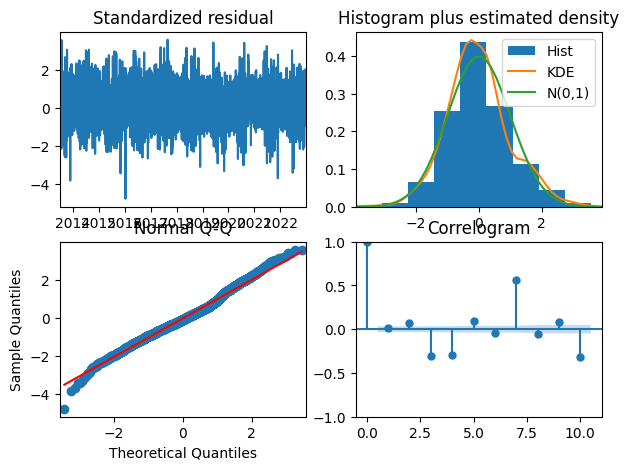

In [8]:
model.plot_diagnostics(figsize=(7,5))
plt.show()

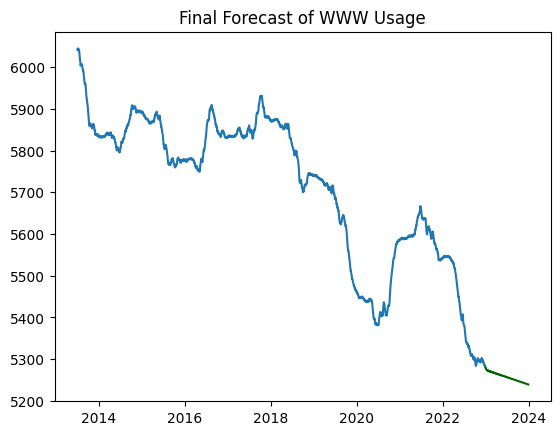

In [9]:
# Forecast
n_periods = 365
fc, confint = model.predict(n_periods=n_periods, return_conf_int=True)

# Plot
plt.plot(df_rolling_year["consommation_brute_electricite_rte"])
plt.plot(fc, color='darkgreen')

plt.title("Final Forecast of WWW Usage")
plt.show()

## 12 Lancez un modèle auto-Arima sur la série originale journalière en incluant les paramètre saisonniers

In [2]:
from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm

df_day = pd.read_csv("data/hdf_daily.csv", index_col="date_heure", parse_dates = True)

model = pm.auto_arima(df_day, start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=5, # maximum p and q
                      min_Q = 0, min_P=0,
                      m=365,              # frequency of series
                      d=None,           # let model determine 'd'
                      D=None,
                      seasonal=True,   # No Seasonality
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True) #algorithme de recherche du meilleur modèle

print(model.summary())

Performing stepwise search to minimize aic


#  3.2 Approche machine learning

## 14.Qu’est ce que la métrique MAPE? 

Mean Absolute Percentage Error: le pourcentage d'erreur moyen de nos prédictions.

## 15. Quel est la particularité des train test split quand on travaille avec des séries temporelles?

On ne peut pas choisir aléatoirement les points du train et les points du tests car si pour un point du test, le point d'avant et le point d'après appartiennent au train. Alors il est assez facile de deviner la valeur du point du test.
Il faut donc couper en deux notre jeu de données, on apprend sur la première partie et test sur la seconde.

## 16. Comment peut-on faire une cross validation avec des séries temporelles?

Il répéter plusieurs fois le découpage soit en faisant des divisions fixe ou en utilisant une fenètre glissante.

## 17.lancez un premier modèle de Naive Drift sur la série désaisonnalisée en réalisant un train test split (en gardant les deux dernières années en test) et en évaluant sur la MAPE.

In [1]:
from sklearn.preprocessing import MinMaxScaler
from darts import TimeSeries
from darts.dataprocessing.transformers import Scaler
from darts.models import NaiveSeasonal, NaiveDrift, AutoARIMA, ARIMA, XGBModel, Prophet
import numpy as np
from darts.metrics import mape, mase, mae, mse,r2_score

The `LightGBM` module could not be imported. To enable LightGBM support in Darts, follow the detailed instructions in the installation guide: https://github.com/unit8co/darts/blob/master/INSTALL.md
/Users/charles/Documents/pythonProject/series_temporelles_electricité/env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.
The `CatBoost` module could not be imported. To enable CatBoost support in Darts, follow the detailed instructions in the installation guide: https://github.com/unit8co/darts/blob/master/INSTALL.md


In [45]:
df_day = pd.read_csv("data/hdf_daily.csv", index_col="date_heure", parse_dates = True)
df_rolling_year = df_day.rolling(window=365,center=True, win_type=None).mean()
df_rolling_year = df_rolling_year[~df_rolling_year["consommation_brute_electricite_rte"].isna()]

df_rolling_year = df_rolling_year.asfreq('d')
df_rolling_year = df_rolling_year.reset_index(names='date')
df_rolling_year['date'] = pd.to_datetime(df_rolling_year.date).dt.tz_localize(None)
 

In [32]:
series = TimeSeries.from_dataframe(df=df_rolling_year, time_col="date", value_cols='consommation_brute_electricite_rte')
train, val = series[:-730], series[-730:]
model = NaiveDrift()            # init
model.fit(train)                      # fit
pred = model.predict(n=730) 

row_dict= {
    'model':'NaiveDrift',
    'mape':mape(val, pred), 
    'mase':mase(val, pred,insample = train, m=7),
    'mae':mae(val, pred), 
    'mse':mse(val, pred),
    'r2': r2_score(val, pred)
}
print(row_dict)

        

{'model': 'NaiveSeasonal', 'mape': 1.3635889340972835, 'mase': 12.343835862937048, 'mae': 73.84536201297004, 'mse': 9236.230487480449, 'r2': 0.39516051381489914}


<Axes: xlabel='date'>

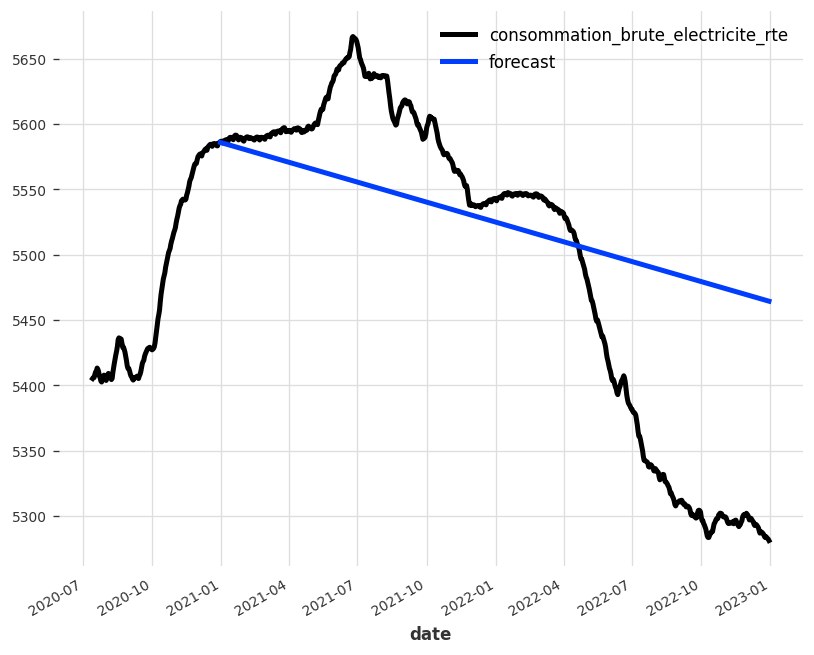

In [33]:
plt.figure(figsize=(8,6))
series[-900:].plot(lw=3)
pred.plot(lw=3, label='forecast')


### On ajoute un scaler et observez si votre MAPE s’est améliorée.

In [29]:
series = TimeSeries.from_dataframe(df=df_rolling_year, time_col="date", value_cols='consommation_brute_electricite_rte')

train, val = series[:-730], series[-730:]

scaler = MinMaxScaler(feature_range=(-1, 1))
scaler = Scaler(scaler)
train = scaler.fit_transform(train)
val = scaler.transform(val)
series_norm = scaler.transform(series)

model = NaiveDrift()            # init
model.fit(train)                      # fit
pred = model.predict(n=730) 

row_dict= {
    'model':'NaiveDrift with normalisation',
    'mape':mape(val, pred), 
    'mase':mase(val, pred,insample = train, m=7),
    'mae':mae(val, pred), 
    'mse':mse(val, pred),
    'r2': r2_score(val, pred)
}
print(row_dict)
            

{'model': 'NaiveSeasonal', 'mape': 39.55378156656466, 'mase': 12.343835862937024, 'mae': 0.22242606821186706, 'mse': 0.08379530465041445, 'r2': 0.3951605138148965}


<Axes: xlabel='date'>

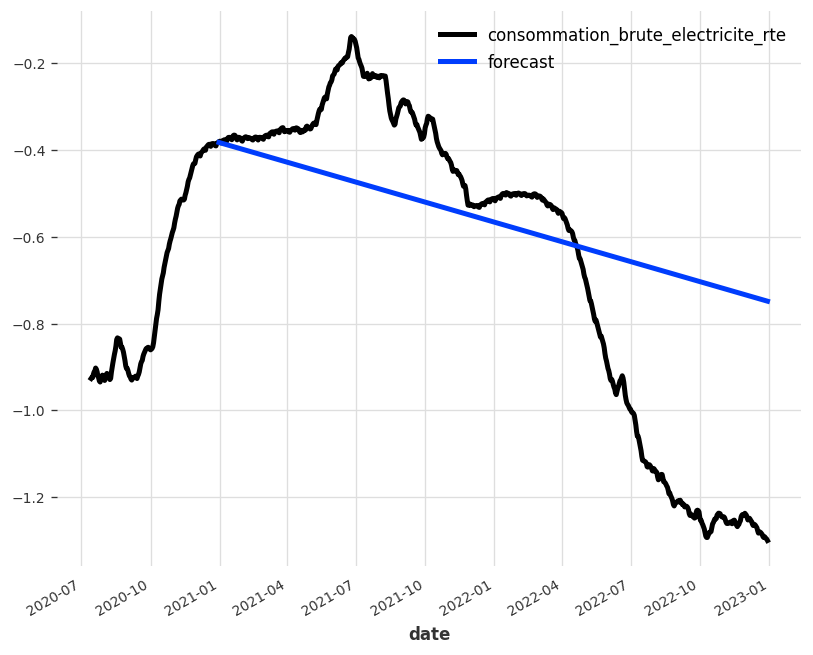

In [31]:
plt.figure(figsize=(8,6))
series_norm[-900:].plot(lw=3)
pred.plot(lw=3, label='forecast')


## 18. Faites la même chose à l’aide d’un Naive seasonal sur la série resample by day. 

In [34]:
df_day = pd.read_csv("data/hdf_daily.csv", index_col="date_heure", parse_dates = True)

df_day = df_day.asfreq('d')
df_day = df_day.reset_index(names='date')
df_day['date'] = pd.to_datetime(df_day.date).dt.tz_localize(None)

In [43]:
series = TimeSeries.from_dataframe(df=df_day, time_col="date", value_cols='consommation_brute_electricite_rte')

train, val = series[:-730], series[-730:]

# scaler = MinMaxScaler(feature_range=(-1, 1))
# scaler = Scaler(scaler)
# train = scaler.fit_transform(train)
# val = scaler.transform(val)
# series_norm = scaler.transform(series)

model = NaiveSeasonal(K=365)           # init
model.fit(train)                      # fit
pred = model.predict(n=730) 

row_dict= {
    'model':'NaiveSeasonal',
    'mape':mape(val, pred), 
    'mase':mase(val, pred,insample = train, m=365),
    'mae':mae(val, pred), 
    'mse':mse(val, pred),
    'r2': r2_score(val, pred)
}
print(row_dict)
            

{'model': 'NaiveSeasonal', 'mape': 9.216347101859125, 'mase': 1.0502099699163385, 'mae': 491.2190850343819, 'mse': 426433.6413217572, 'r2': 0.42754036185647204}


<Axes: xlabel='date'>

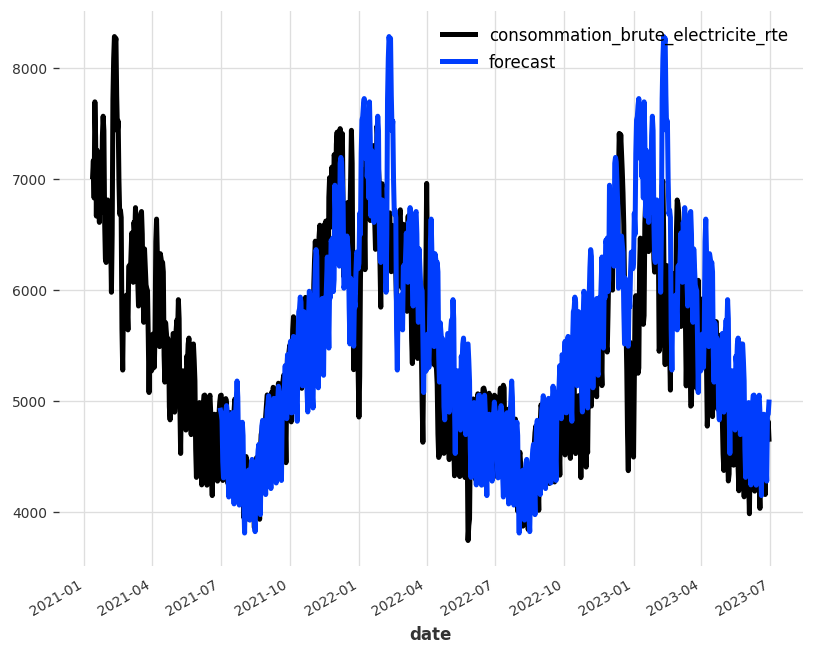

In [44]:
plt.figure(figsize=(8,6))
series[-900:].plot(lw=3)
pred.plot(lw=3, label='forecast')

##  19. Comparez les deux modèles créés précédemment (ARIMA manuel/ Auto Arima sur la série désaisonnalisée)

### 19.1 ARIMA Manuel

In [46]:
df_day = pd.read_csv("data/hdf_daily.csv", index_col="date_heure", parse_dates = True)
df_rolling_year = df_day.rolling(window=365,center=True, win_type=None).mean()
df_rolling_year = df_rolling_year[~df_rolling_year["consommation_brute_electricite_rte"].isna()]

df_rolling_year = df_rolling_year.asfreq('d')
df_rolling_year = df_rolling_year.reset_index(names='date')
df_rolling_year['date'] = pd.to_datetime(df_rolling_year.date).dt.tz_localize(None)
 

In [50]:
series = TimeSeries.from_dataframe(df=df_rolling_year, time_col="date", value_cols='consommation_brute_electricite_rte')

train, val = series[:-730], series[-730:]


model = ARIMA( p=1, q=4, d=1)     # init
model.fit(train)                      # fit
pred = model.predict(n=730) 

row_dict= {
    'model':'ARIMA',
    'mape':mape(val, pred), 
    'mase':mase(val, pred,insample = train, m=365),
    'mae':mae(val, pred), 
    'mse':mse(val, pred),
    'r2': r2_score(val, pred)
}
print(row_dict)   

{'model': 'ARIMA', 'mape': 1.9305342389832996, 'mase': 0.9442594528962572, 'mae': 103.78496535988111, 'mse': 22436.95717670594, 'r2': -0.4692961234251203}


<Axes: xlabel='date'>

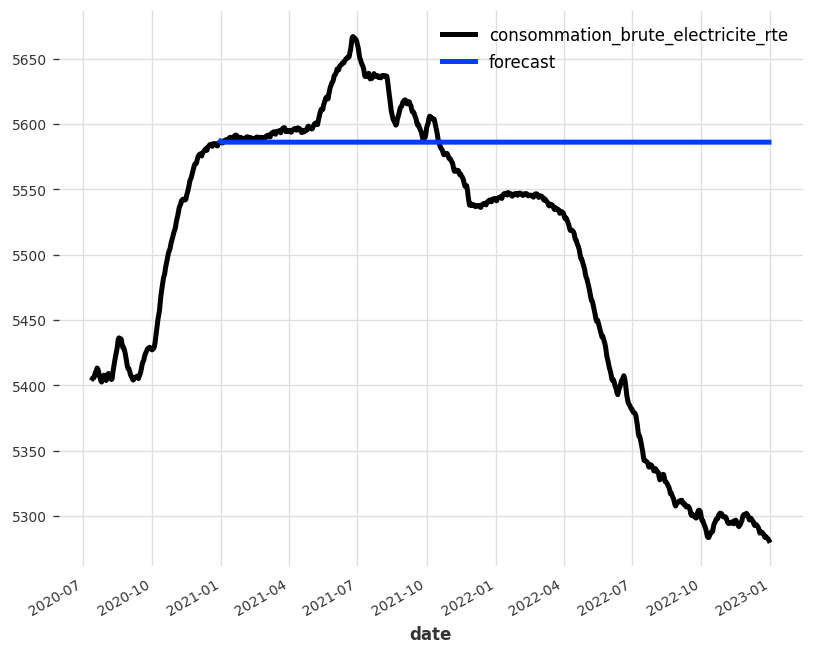

In [48]:
plt.figure(figsize=(8,6))
series[-900:].plot(lw=3)
pred.plot(lw=3, label='forecast')

## 19.2 Auto-Arima

In [51]:
df_day = pd.read_csv("data/hdf_daily.csv", index_col="date_heure", parse_dates = True)
df_rolling_year = df_day.rolling(window=365,center=True, win_type=None).mean()
df_rolling_year = df_rolling_year[~df_rolling_year["consommation_brute_electricite_rte"].isna()]

df_rolling_year = df_rolling_year.asfreq('d')
df_rolling_year = df_rolling_year.reset_index(names='date')
df_rolling_year['date'] = pd.to_datetime(df_rolling_year.date).dt.tz_localize(None)
 

In [52]:
series = TimeSeries.from_dataframe(df=df_rolling_year, time_col="date", value_cols='consommation_brute_electricite_rte')

train, val = series[:-730], series[-730:]


model = AutoARIMA( 
                start_p=1, 
                start_q=1,
                max_p=3, 
                max_q=5,
                test='adf',
                seasonal=False,
                d=None, # it means use the test
                error_action='ignore',  
                suppress_warnings=True, 
                stepwise=True)           # init

model.fit(train)                      # fit
pred = model.predict(n=730) 

row_dict= {
    'model':'ARIMA',
    'mape':mape(val, pred), 
    'mase':mase(val, pred,insample = train, m=365),
    'mae':mae(val, pred), 
    'mse':mse(val, pred),
    'r2': r2_score(val, pred)
}
print(row_dict)   

{'model': 'ARIMA', 'mape': 1.3480984515187064, 'mase': 0.6632763839401914, 'mae': 72.9016970072345, 'mse': 9540.35006651948, 'r2': 0.3752450807630573}


<Axes: xlabel='date'>

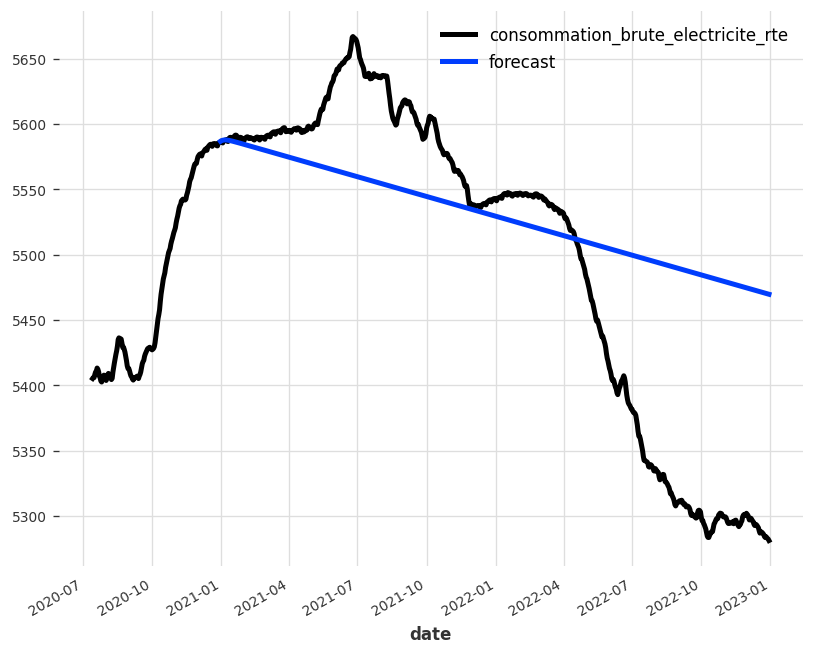

In [53]:
plt.figure(figsize=(8,6))
series[-900:].plot(lw=3)
pred.plot(lw=3, label='forecast')

## 20. Xgboost lag only

In [3]:
df_day = pd.read_csv("data/hdf_daily.csv", index_col="date_heure", parse_dates = True)

df_day = df_day.asfreq('d')
df_day = df_day.reset_index(names='date')
df_day['date'] = pd.to_datetime(df_day.date).dt.tz_localize(None)

In [6]:
series = TimeSeries.from_dataframe(df=df_day, time_col="date", value_cols='consommation_brute_electricite_rte')
train, val = series[:-730], series[-730:]


scaler = MinMaxScaler(feature_range=(-1, 1))
scaler = Scaler(scaler)
train = scaler.fit_transform(train)
val = scaler.transform(val)
series_norm = scaler.transform(series)

lag_to_use = 7
model = XGBModel(lags=lag_to_use) #, uses_future_covariates=True,lags_future_covariates=[1])

model.fit(train)                      # fit
pred = model.predict(n=730) 

row_dict= {
    'model':'ARIMA',
    'mape':mape(val, pred), 
    'mase':mase(val, pred,insample = train, m=365),
    'mae':mae(val, pred), 
    'mse':mse(val, pred),
    'r2': r2_score(val, pred)
}
print(row_dict)  

{'model': 'ARIMA', 'mape': 743.4087377711822, 'mase': 2.4916594862980674, 'mae': 0.47357529654935443, 'mse': 0.3440349776070927, 'r2': -1.7970066799845652}


<Axes: xlabel='date'>

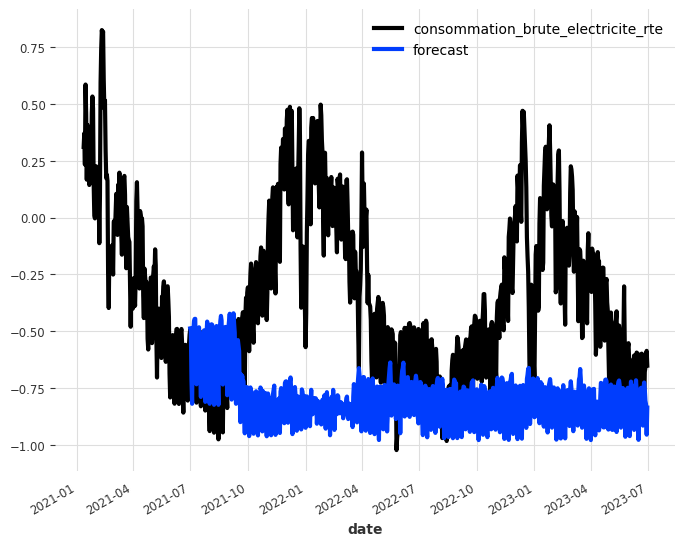

In [7]:
plt.figure(figsize=(8,6))
series_norm[-900:].plot(lw=3)
pred.plot(lw=3, label='forecast')

## 21. Xgboost with future covariates

In [11]:
from sklearn.preprocessing import LabelEncoder

df_day = pd.read_csv("data/hdf_daily.csv", index_col="date_heure", parse_dates = True)

df_day = df_day.asfreq('d')
df_day = df_day.reset_index(names='date')
df_day['date'] = pd.to_datetime(df_day.date).dt.tz_localize(None)
df_day['year'] = df_day['date'].dt.year

# Create a LabelEncoder instance
label_encoder = LabelEncoder()

df_day['month'] = label_encoder.fit_transform(df_day['date'].dt.strftime('%b'))
df_day['day_of_week'] = label_encoder.fit_transform(df_day['date'].dt.strftime('%A'))

In [12]:
df_day.head()

,date,consommation_brute_electricite_rte,year,month,day_of_week
0,2012-12-31,5989.000000,2012,2,1
1,2013-01-01,5412.687500,2013,4,5
2,2013-01-02,6450.125000,2013,4,6
3,2013-01-03,6668.416667,2013,4,4
4,2013-01-04,6667.354167,2013,4,0


In [13]:
series = TimeSeries.from_dataframe(df=df_day, time_col="date", value_cols='consommation_brute_electricite_rte')

from darts import concatenate
future_covariates = concatenate(
    [
    TimeSeries.from_dataframe(df=df_day, time_col="date", value_cols='year'), 
    TimeSeries.from_dataframe(df=df_day, time_col="date", value_cols='month'), 
    TimeSeries.from_dataframe(df=df_day, time_col="date", value_cols='day_of_week') 
    ]
    , axis=1)



In [14]:
train, val = series[:-730], series[-730:]
train_fc, val_fc = future_covariates[:-730], future_covariates[-730:]


In [15]:
scaler = MinMaxScaler(feature_range=(-1, 1))
scaler = Scaler(scaler)
train = scaler.fit_transform(train)
val = scaler.transform(val)
series_norm = scaler.transform(series)

train_fc = scaler.fit_transform(train_fc)
val_fc = scaler.transform(val_fc)

In [24]:
lag_to_use = 2
model = XGBModel(lags=lag_to_use,lags_future_covariates=[1,1,1]) #, uses_future_covariates=True,lags_future_covariates=[1])

model.fit(series=train,future_covariates=train_fc)                      # fit
pred = model.predict(n=729,future_covariates=val_fc) 

row_dict= {
    'model':'Xgboost with future covariates',
    'mape':mape(val, pred), 
    'mase':mase(val, pred,insample = train, m=365),
    'mae':mae(val, pred), 
    'mse':mse(val, pred),
    'r2': r2_score(val, pred)
}
print(row_dict)  

{'model': 'ARIMA', 'mape': 212.4492889438717, 'mase': 0.910874930039501, 'mae': 0.17312472570388235, 'mse': 0.055952603849411246, 'r2': 0.5452496140032136}


<Axes: xlabel='date'>

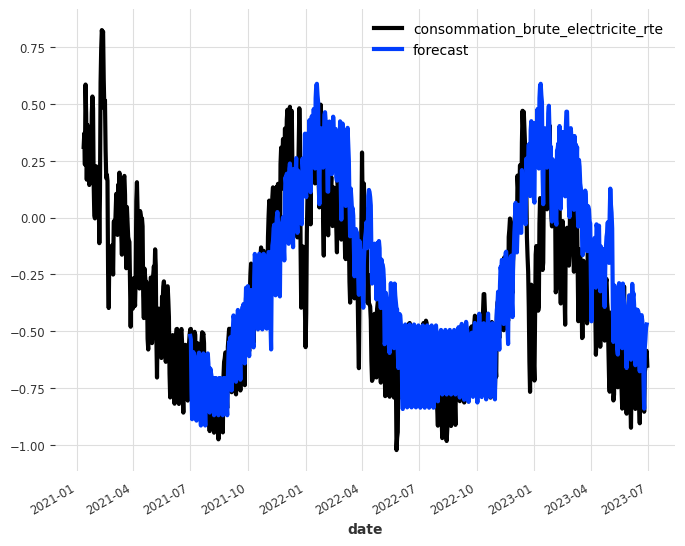

In [25]:
plt.figure(figsize=(8,6))
series_norm[-900:].plot(lw=3)
pred.plot(lw=3, label='forecast')

## 22.Prophets

In [4]:
from sklearn.preprocessing import LabelEncoder

df_day = pd.read_csv("data/hdf_daily.csv", index_col="date_heure", parse_dates = True)

df_day = df_day.asfreq('d')
df_day = df_day.reset_index(names='date')
df_day['date'] = pd.to_datetime(df_day.date).dt.tz_localize(None)


In [5]:
series = TimeSeries.from_dataframe(df=df_day, time_col="date", value_cols='consommation_brute_electricite_rte')

In [6]:
train, val = series[:-730], series[-730:]

In [7]:
scaler = MinMaxScaler(feature_range=(-1, 1))
scaler = Scaler(scaler)
train = scaler.fit_transform(train)
val = scaler.transform(val)
series_norm = scaler.transform(series)

In [9]:
from darts.models import Prophet
model = Prophet(add_seasonalities = {'name':'consommation_brute_electricite_rte','seasonal_periods':365,'fourier_order': 2},
                            country_holidays='FR'
                            ) 
model.fit(series=train)
pred = model.predict(n=729)

row_dict= {
    'model':'Xgboost with future covariates',
    'mape':mape(val, pred), 
    'mase':mase(val, pred, insample = train, m=365),
    'mae':mae(val, pred), 
    'mse':mse(val, pred),
    'r2': r2_score(val, pred)
}
print(row_dict)  

14:01:47 - cmdstanpy - INFO - Chain [1] start processing
14:01:50 - cmdstanpy - INFO - Chain [1] done processing


{'model': 'Xgboost with future covariates', 'mape': 157.56290771290602, 'mase': 0.5900978403466456, 'mae': 0.11215648096060352, 'mse': 0.025066483053886184, 'r2': 0.7962741309588474}


<Axes: xlabel='date'>

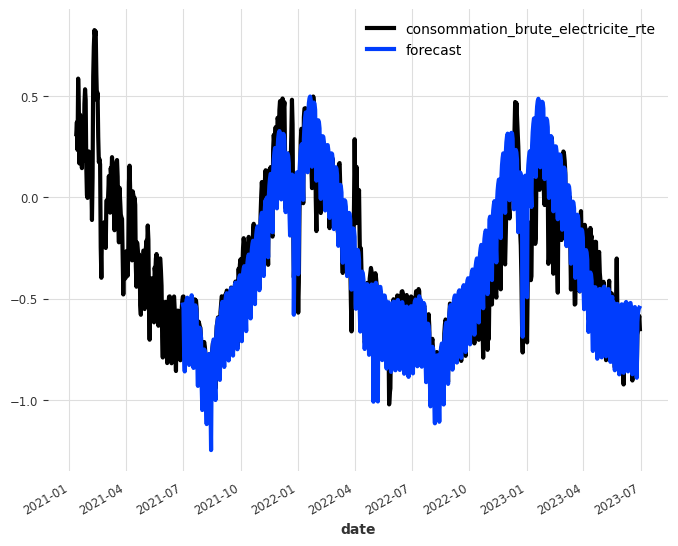

In [10]:
plt.figure(figsize=(8,6))
series_norm[-900:].plot(lw=3)
pred.plot(lw=3, label='forecast')

## 23. BONUS: récoltez des données météo et lancez à nouveau un modèle xgboost puis VARIMAX 

### 23.1 XGBoost

In [71]:
df_temp = pd.read_csv("data/temperature-quotidienne-regionale.csv", index_col="Date", parse_dates = True,sep=";")
df_temp = df_temp["TMoy (°C)"]
df_temp.index = pd.to_datetime(df_temp.index, utc=True)

In [72]:
df_day = pd.read_csv("data/hdf_daily.csv", index_col="date_heure", parse_dates = True)
df_day.index = pd.to_datetime(df_day.index, utc=True)


In [73]:
df_merge=pd.merge(df_day,df_temp, how='inner', left_index=True, right_index=True)
df_merge = df_merge.asfreq('d')
df_merge = df_merge.reset_index(names='date')
df_merge['date'] = pd.to_datetime(df_merge.date).dt.tz_localize(None)

In [74]:
df_merge

,date,consommation_brute_electricite_rte,TMoy (°C)
0,2016-01-01,5478.104167,4.72
1,2016-01-02,5786.604167,8.51
2,2016-01-03,5838.812500,6.70
3,2016-01-04,6635.270833,7.70
4,2016-01-05,6914.333333,6.93
...,...,...,...
2733,2023-06-26,4589.083333,18.09
2734,2023-06-27,4635.541667,17.17
2735,2023-06-28,4759.458333,18.12
2736,2023-06-29,4816.062500,19.07


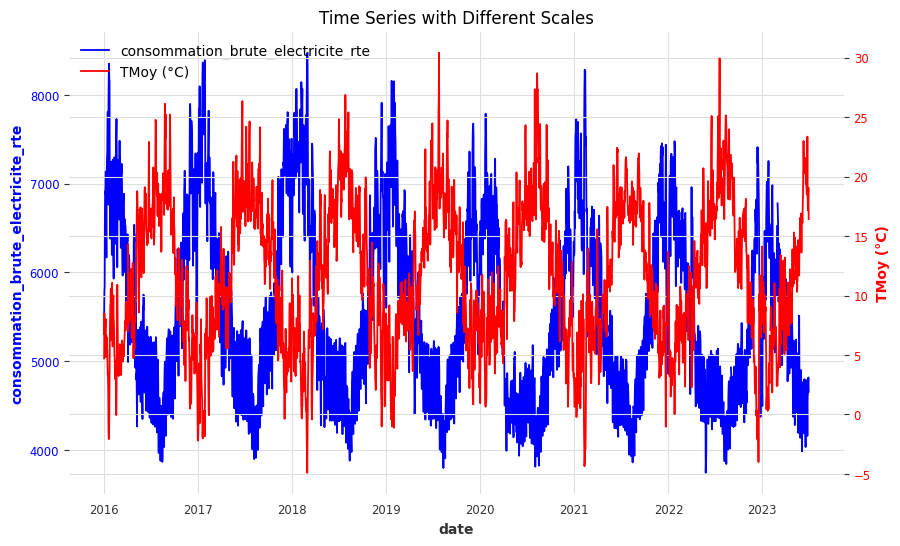

In [75]:
# Create a figure and axis
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot the first time series on the primary y-axis (left)
ax1.plot(df_merge['date'], df_merge['consommation_brute_electricite_rte'], color='b', label='consommation_brute_electricite_rte')
ax1.set_xlabel('date')
ax1.set_ylabel('consommation_brute_electricite_rte', color='b')
ax1.tick_params(axis='y', labelcolor='b')

# Create a secondary y-axis (right)
ax2 = ax1.twinx()

# Plot the second time series on the secondary y-axis (right)
ax2.plot(df_merge['date'], df_merge['TMoy (°C)'], color='r', label='TMoy (°C)')
ax2.set_ylabel('TMoy (°C)', color='r')
ax2.tick_params(axis='y', labelcolor='r')

# Add legends
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
lines = lines1 + lines2
labels = labels1 + labels2
ax1.legend(lines, labels, loc='upper left')

# Set a title
plt.title('Time Series with Different Scales')

# Show the plot
plt.show()

In [76]:
df_merge['year'] = df_merge['date'].dt.year

label_encoder = LabelEncoder()

df_merge['month'] = label_encoder.fit_transform(df_merge['date'].dt.strftime('%b'))
df_merge['day_of_week'] = label_encoder.fit_transform(df_merge['date'].dt.strftime('%A'))

In [77]:
series = TimeSeries.from_dataframe(df=df_merge, time_col="date", value_cols='consommation_brute_electricite_rte')

from darts import concatenate
future_covariates = concatenate(
    [
    TimeSeries.from_dataframe(df=df_merge, time_col="date", value_cols='year'), 
    TimeSeries.from_dataframe(df=df_merge, time_col="date", value_cols='month'), 
    TimeSeries.from_dataframe(df=df_merge, time_col="date", value_cols='day_of_week'),
    TimeSeries.from_dataframe(df=df_merge, time_col="date", value_cols='TMoy (°C)'), 
    ]
    , axis=1)

In [78]:
train, val = series[:-730], series[-730:]
train_fc, val_fc = future_covariates[:-730], future_covariates[-730:]

In [79]:
from darts.dataprocessing.transformers import MissingValuesFiller

transformer = MissingValuesFiller()
train = transformer.transform(train)
val = transformer.transform(val)
train_fc = transformer.transform(train_fc)
val_fc = transformer.transform(val_fc)

In [80]:
scaler = MinMaxScaler(feature_range=(-1, 1))
scaler = Scaler(scaler)
train = scaler.fit_transform(train)
val = scaler.transform(val)
series_norm = scaler.transform(series)

train_fc = scaler.fit_transform(train_fc)
val_fc = scaler.transform(val_fc)

In [81]:
lag_to_use = 2
model = XGBModel(lags=lag_to_use,lags_future_covariates=[1,1,1,7]) #, uses_future_covariates=True,lags_future_covariates=[1])

model.fit(series=train,future_covariates=train_fc)                      # fit
pred = model.predict(n=700,future_covariates=val_fc) 

row_dict= {
    'model':'Xgboost with future covariates',
    'mape':mape(val, pred), 
    'mase':mase(val, pred,insample = train, m=359),
    'mae':mae(val, pred), 
    'mse':mse(val, pred),
    'r2': r2_score(val, pred)
}
print(row_dict)

{'model': 'Xgboost with future covariates', 'mape': 107.6254649031544, 'mase': 0.45950556111207697, 'mae': 0.11689728321431367, 'mse': 0.02463863477515552, 'r2': 0.818082796092734}


<Axes: xlabel='date'>

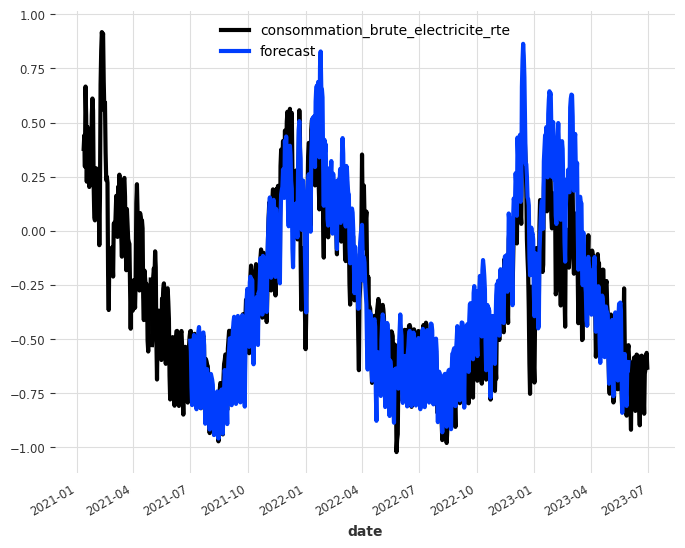

In [82]:
plt.figure(figsize=(8,6))
series_norm[-900:].plot(lw=3)
pred.plot(lw=3, label='forecast')

### 23.2 VARIMAX 

In [117]:
df_temp = pd.read_csv("data/temperature-quotidienne-regionale.csv", index_col="Date", parse_dates = True,sep=";")
df_temp = df_temp["TMoy (°C)"]
df_temp.index = pd.to_datetime(df_temp.index, utc=True)
df_temp = df_temp.rolling(window=365,center=True, win_type=None).mean()
df_temp = df_temp.dropna()

In [118]:
df_day = pd.read_csv("data/hdf_daily.csv", index_col="date_heure", parse_dates = True)
df_rolling_year = df_day.rolling(window=365,center=True, win_type=None).mean()
df_rolling_year = df_rolling_year[~df_rolling_year["consommation_brute_electricite_rte"].isna()]



In [119]:
df_merge=pd.merge(df_rolling_year,df_temp, how='inner', left_index=True, right_index=True)
df_merge = df_merge.asfreq('d')
df_merge = df_merge.reset_index(names='date')
df_merge['date'] = pd.to_datetime(df_merge.date).dt.tz_localize(None)

In [120]:
series = concatenate(
    [
    TimeSeries.from_dataframe(df=df_merge, time_col="date", value_cols='consommation_brute_electricite_rte'), 
    TimeSeries.from_dataframe(df=df_merge, time_col="date", value_cols="TMoy (°C)"), 
    ]
    , axis=1)

In [121]:
train, val = series[:-730], series[-730:]

In [122]:
from darts.dataprocessing.transformers import MissingValuesFiller

transformer = MissingValuesFiller()
train = transformer.transform(train)
val = transformer.transform(val)

In [123]:
scaler = MinMaxScaler(feature_range=(-1, 1))
scaler = Scaler(scaler)
train = scaler.fit_transform(train)
val = scaler.transform(val)
series_norm = scaler.transform(series)

In [124]:
from darts.models import VARIMA
model = VARIMA(p=1,d=1,q=4) #, uses_future_covariates=True,lags_future_covariates=[1])

model.fit(series=train)                      # fit
pred = model.predict(n=700) 

row_dict= {
    'model':'Xgboost with future covariates',
    'mape':mape(val, pred), 
    'mase':mase(val, pred,insample = train, m=359),
    'mae':mae(val, pred), 
    'mse':mse(val, pred),
    'r2': r2_score(val, pred)
}
print(row_dict)

/Users/charles/Documents/pythonProject/series_temporelles_electricité/env/lib/python3.10/site-packages/statsmodels/tsa/statespace/varmax.py:161: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'
/Users/charles/Documents/pythonProject/series_temporelles_electricité/env/lib/python3.10/site-packages/statsmodels/tsa/statespace/varmax.py:326: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  endog = np.require(endog.fillna(method='backfill'), requirements="W")
/Users/charles/Documents/pythonProject/series_temporelles_electricité/env/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


{'model': 'Xgboost with future covariates', 'mape': 154.3130287606173, 'mase': 0.861923592155331, 'mae': 0.4215047624863616, 'mse': 0.30741712391777354, 'r2': -0.2360911318951685}


<Axes: xlabel='date'>

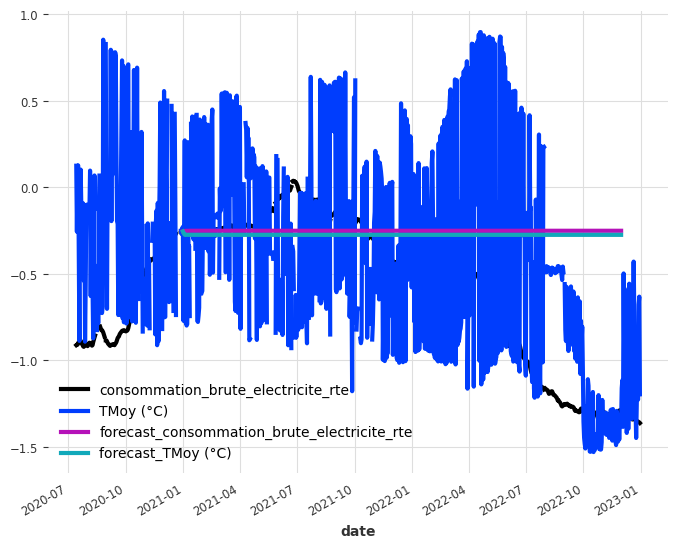

In [125]:
plt.figure(figsize=(8,6))
series_norm[-900:].plot(lw=3)
pred.plot(lw=3, label='forecast')